In [1]:
from __future__ import annotations
from typing import List, Tuple
from pathlib import Path
from requests import Response
from datetime import datetime, timezone
from concurrent.futures import ThreadPoolExecutor, as_completed

import pandas as pd

from scraping_kit import load_db_and_bots
from scraping_kit.bot_scraper import BotScraper
from scraping_kit.db.models.users import UserList
from scraping_kit.db.models.follow import Follow, FollowList
from scraping_kit.db.db_twitter import DBTwitter, get_check_follow, wrap_check_follow
from scraping_kit.db.filters import filter_follow
from twitter45.params import ArgsCheckFollow

path_data = Path("data")
df_accounts = pd.read_excel(path_data / "twitter_accounts.xlsx").sort_values("followersCount", ascending=False)
db_tw, bots = load_db_and_bots(path_data, "scrape_tw")

Collection Names: ['tweet_user', 'raw', 'cursors', 'trends', 'search', 'user', 'user_suspended', 'topics', 'follows']
Bots: bots=[BotScraper(acc_name='Vera')]


In [2]:
list_screennames = df_accounts["screenName"].to_list()
N_BESTS = 36
#MAX_WORKERS = 40
#r = db_tw.collect_usertimeline(
#    list_screennames,
#    bots = bots,
#    max_workers = MAX_WORKERS,
#    days_to_update = 14
#)
users = db_tw.get_user_list(list_screennames)
users.keep_bests(N_BESTS)

In [3]:
DAYS_TO_UPDATE_FOLLOW = 120     # 4 Months.
MAX_WORKERS = 40

#with ThreadPoolExecutor(max_workers=MAX_WORKERS) as pool:
#    iter_futures = (pool.submit(wrap_check_follow, db_tw, bots.random_bot_2(), source, target, DAYS_TO_UPDATE_FOLLOW)
#                    for source, target in users.iter_profile_pairs())
#    n = len(users)
#    num_iters = n * (n - 1)
#    for i, future in enumerate(as_completed(iter_futures), 1):
#        is_download = future.result()
#        txt_iter = f"{i}/{num_iters}"
#        if is_download:
#            txt_iter += " | Download sucessfull"
#        print(txt_iter)

In [4]:
from scraping_kit.graph_follow import GraphFollows

graph_follow = GraphFollows.from_users_db(db_tw, users)
#cairo_plot = graph_follow.plot()
#cairo_plot

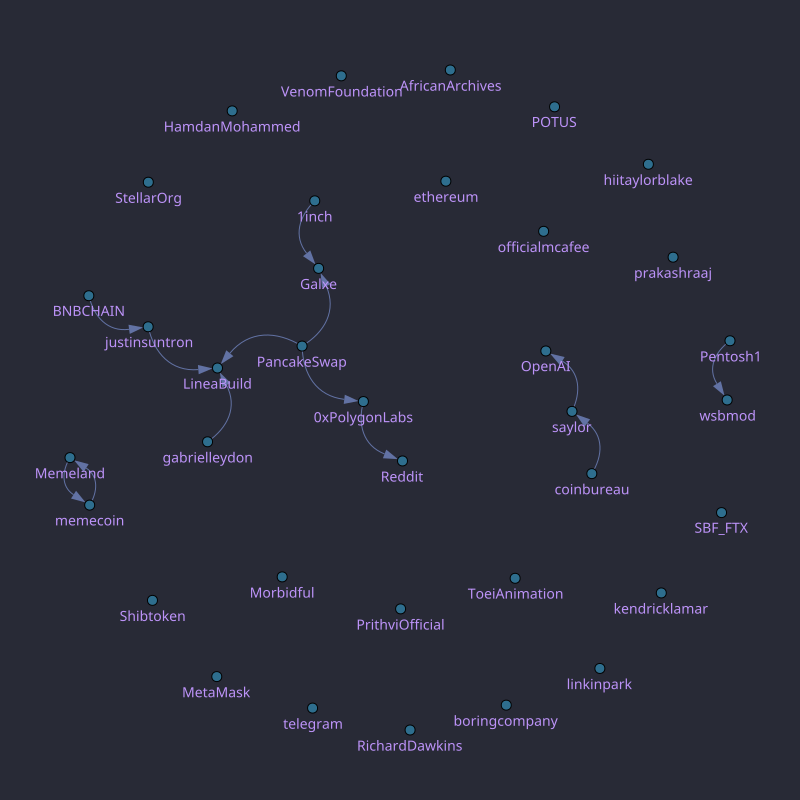

In [5]:
graph_follow.plot()

# Keywords

In [ ]:
user_full_data = db_tw.get_user_full_data(
    profile = users[0].profile,
    date_i = datetime(2023, 12, 1, tzinfo=timezone.utc),
    date_f = datetime.now(tz=timezone.utc)
)

In [ ]:
from wordcloud import WordCloud

def get_blacklist_words(path_extra_words: Path = None) -> set:
    import nltk
    from nltk.corpus import stopwords
    from wordcloud import STOPWORDS

    nltk.download('stopwords', quiet=True)
    blacklist_words = set()
    blacklist_words.update(STOPWORDS)
    blacklist_words.update(stopwords.words('english'))
    if path_extra_words is not None:
        pass
    return blacklist_words

blacklist_words = get_blacklist_words()

In [ ]:
blacklist_words

In [ ]:
#blacklist_words.update()
user_words = set([
    "https", "and", "to", "the", "of", "a", "my", "i",
    "in", "that", "have", "as", "by", "do", "every"
])

In [ ]:
df = pd.DataFrame({"words": list(user_words)})
df.to_excel(db_tw.path_blacklist_words)

In [ ]:
full_text = " ".join([tweet.text for tweet in user_full_data.tweets_user])

wordcloud = WordCloud(
    width = 800,
    height = 800, 
    background_color ='black', 
    stopwords = blacklist_words,
    min_font_size = 10
).generate(full_text)

import matplotlib.pyplot as plt
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud) 
plt.axis("off")
plt.tight_layout(pad = 0) 

plt.show()

In [ ]:
all_keys = []
all_values = []
for k, v in wordcloud.process_text(full_text).items():
    all_keys.append(k)
    all_values.append(v)
df = pd.DataFrame({"word": all_keys, "count": all_values})
df.sort_values("count", ascending=False).head(50)

In [ ]:
for user in users:
    cursor = db_tw.get_cursor_by_user(user)


In [ ]:
#from datetime import datetime, timezone
#date_i = datetime(2023, 1, 1, tzinfo=timezone.utc)
#date_f = datetime(2023, 1, 14, tzinfo=timezone.utc)
#users_full_data = db_tw.get_users_full_data(list_screennames, date_i, date_f)
#for user in users_full_data.all_users:
#    if len(user.tweets_user) != 0:
#        #display(user.tweets_user)
#        continue

In [ ]:
from scraping_kit.db.models.users import User
from twitter45.params import ArgsUserReplies
def collect_user_replies(list_screennames: List[str]):
    for user in list_screennames:
        req_args = ArgsUserReplies.from_screenname(user.profile)

